In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import fish_models.utils
import robofish.io

In [27]:
fishes = 2

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import random

class RandomForestFishModel(fish_models.gym_interface.AbstractModel):
    def __init__(self):
        """
        Parameters
        ---------
        n_estimators : int, default=100
            The number of trees in the forest.
        max_depth : int, default=None
            The maximum depth of the tree. 
            If None, then nodes are expanded until all leaves are pure 
            or until all leaves contain less than min_samples_split samples.
        random_state : int, RandomState instance or None, default=None
            Controls both the randomness of the bootstrapping 
            of the samples used when building trees

        """
        self.clf = RandomForestRegressor(n_estimators=255, max_depth=None, random_state=None)
        
    def choose_action(self, view: np.ndarray):
        """
        Predict regression target for given view of a virtual fish.
        The predicted regression target of an input sample is computed 
        as the mean predicted regression targets of the trees in the forest.
        """
        
        prediction = self.clf.predict([view])
        
        speed = prediction[0][0]
        turn = prediction[0][1]
        
       
        return speed, turn
        
        
    def fit(self, dset):
        """
        Build a forest of trees from the given fish dset
        
        Dset will be devided into the training input samples aka views
        and target values aka tuple of actions as real numbers in regression
        """
        
        views = dset[:]["views"]
        actions = dset[:]["actions"]
        
        # Fit
        self.clf.fit(views, actions)
        
        print("Fit done")
        
    
model = RandomForestFishModel()

In [29]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [30]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading data from 10 files.


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating views from 10 files.


100%|██████████| 10/10 [00:27<00:00,  2.78s/it]

Status of IoDataset:
The first 3 dimensions are reduced from (10, 2, 8990) to (179800)
poses	(179800, 3):	consisting of x, y, orientation.
actions	(179780, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(179780, 9):	4 fish_bins and 5 wall ray casts.



In [31]:
model.fit(dset)

Fit done


In [39]:
generator = fish_models.gym_interface.TrackGeneratorGym(
    model, dset.world_size, dset.frequency, raycast=raycast
)

track = generator.create_track(n_guppies=fishes, trackset_len=10000)

100%|██████████| 9999/9999 [09:57<00:00, 16.73it/s]  


In [40]:
f = generator.as_io_file(track)
f.save_as("output/random_forest.hdf5")

<HDF5 file "d52f8204-4933-4883-996d-f8ca3d811704" (mode r+)>

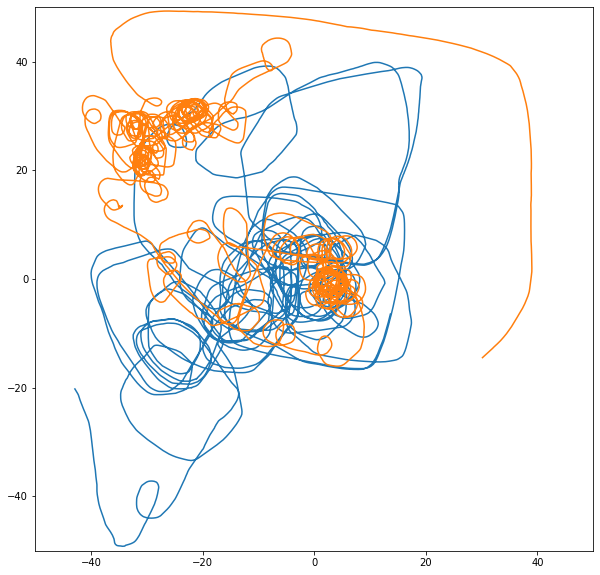

In [41]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()

In [42]:
def trajectory_generator(model_name, model, raycast, dset):
    generator = fish_models.gym_interface.TrackGeneratorGym(
    model, dset.world_size, dset.frequency, raycast=raycast
    )
    # Generate raycast file
    # initial_poses = dset.poses[0, :, 0]
    for i in range(50):
        timesteps = 10000
        #initial_poses = np.array([[0.0, 0.0, 0.0], [0.0, 3.0, 0.0]])
        track = generator.create_track(2, timesteps)
        f = generator.as_io_file(track)
        f.save_as("output/{}_modeldata/__generated{}.hdf5".format(model_name, str(i)))

In [43]:
trajectory_generator("RandomForestRegressor", model, raycast, dset)

100%|██████████| 9999/9999 [08:48<00:00, 18.92it/s]
